In [1]:
import os

import rdkit.Chem as Chem
from rdkit.Chem import Draw

import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

import timeit
import multiprocessing
from mi_collections.mol2vec.model import Mol2Vec
from mi_collections.chemutils import get_mol

mol2vec = Mol2Vec(model_path="../models/model_300dim.pkl")


def compute_mol2vec(mols, n_jobs=8, n_batch=200):
    def make_batch(mols, n_batch):
        prev_index = 0
        mols_list = []
        for index in range(0, len(mols) + n_batch, n_batch):
            if index == 0:
                continue
            mols_list.append(mols[prev_index:index])
            prev_index = index
        return mols_list

    start = timeit.default_timer()
    mol_list = make_batch(mols, n_batch)
    with multiprocessing.Pool(n_jobs) as p:
        vecs = list(
            p.map(mol2vec.fit_transform, mol_list),
        )
    vecs = np.vstack(vecs)
    stop = timeit.default_timer()
    print("Time: ", stop - start)
    return vecs

In [15]:
target = "ZINC"
n_sample = 10000

if target == "ZINC":
    path = "../data/zinc/all.txt"
    gen_path = "../outputs/dist/ZINC_sample10000.csv"
elif target == "GuacaMol":
    path = "../data/guacamol/all.smi"
    gen_path = "../outputs/dist/GuacaMol_sample10000.csv"

else:
    path = None
    gen_path = None


# TRAINING SET
df = pd.read_csv(path, header=None)
rand = np.random.choice(df.shape[0], n_sample)
df = df.iloc[rand, :]
df.columns = ["smiles"]
mols = [get_mol(s) for s in tqdm(df.smiles)]

100%|██████████| 10000/10000 [00:01<00:00, 7662.47it/s]


In [16]:
vecs = compute_mol2vec(mols, n_jobs=4)
vecs.shape

Time:  2.9095992780057713


(10000, 300)

In [17]:
from sklearn.manifold import TSNE


tsne = TSNE(verbose=1)
v = tsne.fit_transform(vecs)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 8.858782
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.439133
[t-SNE] KL divergence after 1000 iterations: 2.184786


In [20]:
# generated molecules
smiles = pd.read_csv(gen_path, index_col=0).to_numpy().flatten()
gen_smis = [s for s in smiles]
gen_mols = [get_mol(s) for s in gen_smis]
gen_vecs = compute_mol2vec(gen_mols, n_jobs=4)
tsne = TSNE(verbose=1)
gen_v = tsne.fit_transform(gen_vecs)

Time:  3.776727555086836
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 2.465s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.397507
[t-SNE] KL divergence after 1000 iterations: 2.901681


/usr/local/opt/pyenv/versions/miniconda3-4.7.12/envs/rdkit/lib/python3.7/site-packages/seaborn/distributions.py:1213: UserWarning: The following kwargs were not used by contour: 'cmaps'
  **contour_kws,
/usr/local/opt/pyenv/versions/miniconda3-4.7.12/envs/rdkit/lib/python3.7/site-packages/seaborn/distributions.py:1213: UserWarning: The following kwargs were not used by contour: 'cmaps'
  **contour_kws,


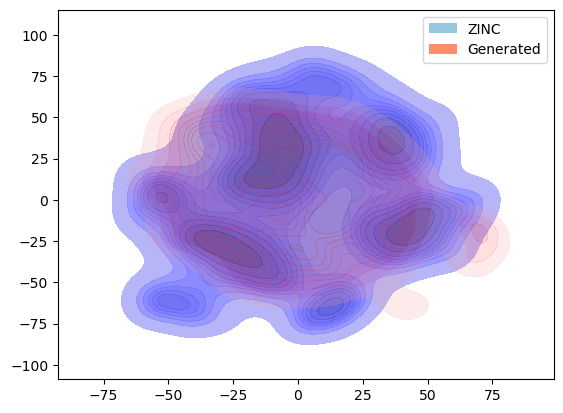

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


figure, _ = plt.subplots()
ax = sns.kdeplot(
    x=v[:, 0],
    y=v[:, 1],
    color="blue",
    cmaps="Blues",
    label=target,
    shade=True,
    alpha=0.9,
    legend=True,
)
ax2 = sns.kdeplot(
    x=gen_v[:, 0],
    y=gen_v[:, 1],
    color="red",
    cmaps="Reds",
    label="Generated",
    shade=True,
    alpha=0.2,
    legend=True,
)
handles = [
    mpatches.Patch(facecolor=plt.cm.Blues(100), label=target),
    mpatches.Patch(facecolor=plt.cm.Reds(100), label="Generated"),
]
plt.legend(handles=handles)
plt.show()

In [ ]:
from rdkit.Chem.QED import qed

with multiprocessing.Pool(8) as p:
    qed_scores = list(p.map(qed, mols))

with multiprocessing.Pool(8) as p:
    gen_qed_scores = list(p.map(qed, gen_mols))

In [ ]:
figure, _ = plt.subplots()
ax = sns.kdeplot(
    qed_scores,
    #     color="blue",
    #     cmaps="Blues",
    label="QED",
    shade=True,
    alpha=0.2,
    legend=True,
)